In [23]:
import os
import sys
import json
import subprocess
import shutil
import random
import re

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import sumolib
import importlib
from pprint import pprint
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import vehParameters
import osmAPI as osm
import LLAMAconnect

FOLDER_NAME = "unicamp"

### Defining paths and setting up osm.sumocfg file

In [24]:
def add_xml_child(file_path, parent_tag, child_tag, child_value):
    """
    Adds a new child parameter inside a specified parent tag in the XML configuration file.
    If the parent tag does not exist, it creates a new parent tag (<parameter>) with the child.
    It also checks if the child element already exists to prevent duplicates.

    Args:
        file_path (str): Path to the XML configuration file.
        parent_tag (str): The parent tag under which to add the child (e.g., 'input').
        child_tag (str): The child tag to add (e.g., 'additional-files').
        child_value (str): The value to set for the new child tag.

    Returns:
        bool: True if the addition was successful, False otherwise.
    """
    try:
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find the parent element by tag
        parent_elem = root.find(parent_tag)
        if parent_elem is None:
            print(f"Parent tag '{parent_tag}' not found. Creating new parent tag.")
            parent_elem = ET.Element(parent_tag)
            root.append(parent_elem)
            print(f"Created new parent tag <{parent_tag}>.")

        # Check if the child element already exists inside the parent element
        existing_child = parent_elem.find(child_tag)
        if existing_child is not None: 
            
            if existing_child.get('value') == child_value:
                print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                return False
            else:
                print(f"Child <{child_tag}> already exists. Updating value to '{child_value}'.")
                existing_child.set('value', child_value)
                tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
                print("XML file updated successfully.")
                return True

        # Create the new child element and set its value
        new_child = ET.Element(child_tag)
        new_child.set('value', child_value)
        print(f"Created <{child_tag}> with value '{child_value}'.")

        # Add the new child to the parent element
        parent_elem.append(new_child)
        print(f"Added <{child_tag}> to <{parent_tag}>.")

        # Write the updated XML to the file
        tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
        print("XML file updated successfully.")
        return True

    except ET.ParseError as e:
        print(f"XML Parsing error: {e}")
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [25]:
NET_PATH = f'{FOLDER_NAME}/osm.net.xml'
ADDITONALS_PATH = f'{FOLDER_NAME}/park.add.xml'
SUMOCFG_PATH = f'{FOLDER_NAME}/osm.sumocfg'
PA_REROUTER_PATH = f'{FOLDER_NAME}/pa_rerouter.xml'

# Setting up additional files
add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', "park.add.xml, pa_rerouter.xml")

# Setting up time to teleport as 
# -1 (never teleport): Vehicles will never teleport, but this could cause deadlock.
time_to_teleport = '100'
add_xml_child(SUMOCFG_PATH, 'processing', 'time-to-teleport', time_to_teleport)

# Adding lateral resolution to use SubLane model
add_xml_child(SUMOCFG_PATH, 'parameters', 'lateral-resolution', '0.8')

net = sumolib.net.readNet(NET_PATH)
parkingAreas = list(sumolib.output.parse(ADDITONALS_PATH, "parkingArea"))

Child <additional-files> with value 'park.add.xml, pa_rerouter.xml' already exists. Skipping addition.
Child <time-to-teleport> with value '100' already exists. Skipping addition.
Child <lateral-resolution> with value '0.8' already exists. Skipping addition.


# Routines

In [26]:
def flush_print():
    sys.stdout.write("\r")  # Move the cursor to the beginning of the line
    sys.stdout.write(" " * 50)  # Overwrite with spaces to clear the line
    sys.stdout.write("\r")  # Move back to the beginning again

In [27]:
def has_parking_spot(lanes, parkingAreas):
    # Example of parkingArea:
    # <parkingArea id="pa-1046248579#0" lane="-1046248579#0_0" roadsideCapacity="94" length="5.00"/>
    # Returns parkingArea id if there is a parking spot in the lane
    lane_ids = [lane.getID() for lane in lanes]
    for park in parkingAreas:
        if park.lane in lane_ids:
            return park.id
    return False

In [28]:
def getClosestEdges(lat, lon, radius, maxEdges=10):
    # Gets the 10 closest edges to the given lat, lon
    x, y = net.convertLonLat2XY(lon, lat)
    edges = net.getNeighboringEdges(x, y, radius)
    closestEdges = []
    if (len(edges) > 0):
        distanceAndEdges = sorted([(dist, edge) for edge, dist in edges], key=lambda x:x[0])

        ## Checking if the edge found can be used by passenger car
        for dist, edge in distanceAndEdges:
            if edge.allows('passenger'):
                closestEdges.append(edge)

    if len(edges) == 0:
        print(f'No edges found for {lat}, {lon}. Perhaps location is not inside the network or there are no viable roads inside the radius.')
        return None
    
    return closestEdges

In [29]:
def getParkingSpot(lat, lon, radius, parkingAreas):
    # Get the parking spot closest to the given lat, lon
    # Used to set stops for the vehicles

    edges = getClosestEdges(lat, lon, radius)
    # Look for parking spots
    for i in range(len(edges)):
        parking_spot = has_parking_spot(edges[i].getLanes(), parkingAreas)
        if parking_spot:
            return parking_spot
    print(f"No parking spot found close to {lat}, {lon}. Perhaps decrease the radius?")
    return None

In [30]:
def getPath(location_time_list, parkingAreas, steps_per_stop = 10):
    # All that is needed to create the trip are the stops (parking areas) and the start and end edges.
    # The duarouter is responsible for finding the path between the edges going through the stops.
    # Here, we get the edges and stops that are going to be sent to LLAMA to create the trip.

    # 'coordinates' is a list of tuples with the latitude and longitude of the points of interest, for example IC, FEEC, IC means that
    # the vehicle will start from IC, stop at a parking lot close to FEEC, and then back to IC.
    # The first and last coordinates should be edges and the others should be parking spots.
    # `steps_per_stop` is the number of simulation steps that the vehicle will stay at each stop.

    # Departure for 7 is 0, 8 is 100, 9 is 200 and so on
    stop_durations = []
    departures = list(location_time_list.keys())
    stop_durations.append(-1) # Indicates this is an edge and not a parking spot

    path = []
    locations = list(location_time_list.values())
    home = getClosestEdges(*locations[0], radius)[0].getID()
    path.append(home)
    
    for i in range(1, len(locations)-1):
        stop_durations.append(steps_per_stop * (departures[i] - departures[i - 1]))
        ps = getParkingSpot(*locations[i], radius, parkingAreas)
        if ps is not None:
            path.append(ps)
        else:
            print(f"Could not find parking spot for {locations[i]}")
            raise Exception(f"Could not find parking spot for {locations[i]}")

    path.append(home)
    stop_durations.append(-1)
    
    return path, stop_durations

In [31]:
def clean_response(institutes):
    cleaned_institutes = []
    for institute in institutes:
        # Remove parenthesis and everything after it
        institute = re.sub(r'\(.*', '', institute).strip()
        
        # Split by hyphen and take the longest slice
        parts = institute.split('-')
        longest_part = max(parts, key=len).strip()
        # Split by '/' and add both parts to the cleaned_institutes list
        if '/' in longest_part:
            parts = longest_part.split('/')
            for part in parts:
                part = part.strip()
                if part not in cleaned_institutes:
                    cleaned_institutes.append(part)
        else:
            if longest_part not in cleaned_institutes:
                cleaned_institutes.append(longest_part)
        
    return cleaned_institutes

### Gathering important places in the university

In [34]:
# IMPORTANT: You can try to automatically get the Institutes and Colleges from the OSM API, but this is not guaranteed to work. Sometimes buildings are not tagged and sometimes their names are not what you expect.
importlib.reload(osm)
uni_center_lat, uni_center_lon = -22.81625871835352, -47.0669736555866
uni_radius = 700
filters = ['Instituto', 'Faculdade', 'Departamento'] # Only buildings with these words in the name will be considered (use this wisely to get the desired buildings, because the API retrieves all buildings that are marked as colleges or university buildings)

resp = osm.find_nearby_university_buildings(uni_center_lat, uni_center_lon, uni_radius, filters)
institutes = [i['name'] for i in resp]

print(len(institutes), institutes)
institutes = clean_response(institutes) # Clean the names of the institutes, removing any acronyms or parenthesis that may be present
print(len(institutes), institutes) # Sometimes the API returns the same building with different names, so this is a way to reduce the number of duplicates

17 ['IC - Instituto de Computação', 'Instituto de Filosofia e Ciências Humanas - Pós Graduação', 'Departamento de Eletrônica Quântica', 'Faculdade de Engenharia Civil', 'Instituto de Geociências', 'Faculdade de Engenharia Elétrica e de Computação', 'Instituto de Economia (Pavilhão de Pós-Graduação', 'Instituto de Economia (Pavilhão administrativo)', 'Instituto de Economia (Biblioteca - Centro de Documentação Lucas Gamboa)', 'Instituto de Economia (Pavilhão de Graduação)', 'Instituto de Biologia', 'Instituto de Física Gleb Wataghin', 'Instituto de Estudos da Linguagem', 'Instituto de Química', 'IA - Instituto de Artes', 'FE - Faculdade de Educação', 'FEAGRI - Faculdade de Engenharia Agrícola']
14 ['Instituto de Computação', 'Instituto de Filosofia e Ciências Humanas', 'Departamento de Eletrônica Quântica', 'Faculdade de Engenharia Civil', 'Instituto de Geociências', 'Faculdade de Engenharia Elétrica e de Computação', 'Instituto de Economia', 'Instituto de Biologia', 'Instituto de Física

### Generating routines via LLM

In [35]:
# It is important not to use short names of institutes, like IB for institute of biology, because the LLM will not be able to assign the students to the correct institute.
places ={
    'leisure': ["bar", "mall", "library", "park", "garden"],
    'eating': ["restaurant", "cafe"],
    'shopping': ["clothes", "mall", "supermarket", "department_store", "fuel"],
    'sports': ["fitness_centre"],
    'institute': institutes, # Here, you could use the places found above or manually add the names of the institutes/colleges/faculties
    
}

student_info = "O estudante é um estudante de ciências ambientais."
importlib.reload(LLAMAconnect)
number_of_trips = 4
responses = LLAMAconnect.generate_response_trips(student_info, places, number_of_trips) # number of trips defaults to 5
for i in range(3):
    pprint(json.loads(responses[i]))
    print()

 25%|██▌       | 1/4 [00:00<00:01,  1.51it/s]

Error: Invalid location generated 'Restaurant'
Invalid response. Generating a new one.
Error: Invalid location generated '#1'
Invalid response. Generating a new one.


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

{'10': {'activity': 'study', 'location': 'Instituto de Geociências'},
 '11': {'activity': 'study', 'location': 'Instituto de Geociências'},
 '12': {'activity': 'lunch', 'location': 'restaurant'},
 '13': {'activity': 'leisure', 'location': 'library'},
 '14': {'activity': 'study', 'location': 'Instituto de Geociências'},
 '15': {'activity': 'study', 'location': 'Instituto de Geociências'},
 '16': {'activity': 'sports', 'location': 'fitness_centre'},
 '17': {'activity': 'shopping', 'location': 'supermarket'},
 '18': {'activity': 'dinner', 'location': 'restaurant'},
 '19': {'activity': 'leisure', 'location': 'park'},
 '20': {'activity': 'relax', 'location': 'home'},
 '21': {'activity': 'relax', 'location': 'home'},
 '22': {'activity': 'relax', 'location': 'home'},
 '23': {'activity': 'sleep', 'location': 'home'},
 '7': {'activity': 'wake up', 'location': 'home'},
 '8': {'activity': 'study', 'location': 'Instituto de Geociências'},
 '9': {'activity': 'breakfast', 'location': 'cafe'}}

{'10'

The getHome function must be set to the desired student home location

### Using OSM API to get coordinates

In [36]:
def getHome():
    # Should be a random value considering where students live
    return (-22.819937502599075, -47.07499882511951)

In [37]:
def getCoords(trip, sulfixo, institutes, start_radius, step_radius, limit_radius, n_options = 3):
    # Returns a dictionary with the latitude and longitude of the locations of interest
    # The suffix is the name of the state, city and neighborhood that will be added to the end of each location to improve the search
    # 'start_radius' is the initial radius of the search, 'step_radius' is the amount that will be added to the radius if the location is not found and 'limit_radius' is the maximum radius that will be used. After that, the student will choose not to leave the place he is at.
    # 'n_options' is the number of options of places we ideally want to find to choose from. This only applies while the limit_radius is not exceeded
    
    coords = {} # Coordinates for every place the student will visit
    ignore = {} # Stores combinations that have already been tested, for example, if library to mall was tested before and was
    importlib.reload(osm)
    for i in range(len(trip)):
        local = trip[f'{i + 7}']['location']
        local_comp = local + ", " + sulfixo

        if local in coords.keys():
            continue
        
        if local == 'home':
            coords['home'] = getHome()
            continue
        
        elif local in institutes:
                result = osm.geocode_address(local_comp)
                
                if not result:
                    raise Exception(f"Could not get coordinates for {local}, maybe its name is not correct")

                lat, lon = result[0]['latitude'], result[0]['longitude']
                print(f"\033[1mFound {local} at {lat}, {lon}.\033[0m")
        else:
            found = False
            print(f"Looking for {local}...", end='', flush=True)

            # Storing the previous location to use as a reference for the next search
            previous = coords[trip[f'{i + 6}']['location']]
            result = osm.find_nearby_building(previous[0], previous[1], local, radius=start_radius)
            expanded = start_radius
            if len(result) > 0:
                found = True

            # If the location is not found or there are less optios than expected, expand the search radius
            while len(result) == 0 or len(result) < n_options:
                expanded += step_radius

                if expanded > limit_radius:
                    break

                result = osm.find_nearby_building(previous[0], previous[1], local, radius=expanded)
                if found == False and (len(result) > 0):
                    found = True # Found at least one option, but will keep looking for more until the limit is reached

            if found == False:
                result = [{'latitude': previous[0], 'longitude': previous[1]}]
                flush_print()
                print(f"Could not find {local} in a radius of {limit_radius} meters. The student will not leave the place he is currently at.")
            else:
                random.shuffle(result) # Randomize the results to avoid always getting the absolute closest building
                lat, lon = result[0]['latitude'], result[0]['longitude']
                flush_print()
                print(f"Found {len(result)} options for {local}: {[x['name'] for x in result]}")
                print(f"\033[1m{local} picked: {result[0]['name']} at {lat}, {lon}.\033[0m")

        
        coords[f'{local}'] = (lat, lon)
        
    return coords

In [38]:
def coordsToTrip(trip, coords):
    location_time = {}
    home = coords['home'] # Gets a random home location for each student
    last = home
    location_time[7] = last
    
    for j in range(1, len(trip)):
        local_coords = coords[trip[f'{j + 7}']['location']]
        if local_coords != last:
            location_time[j + 7] = local_coords
            last = local_coords

    return location_time

In [39]:
sufixo = "Campinas, SP, Brazil"
trips = {}
location_time_list = []
radius = 200
for i in range(len(responses)):
    json_response = json.loads(responses[i])
    trips[i] = json_response
    print(f"Getting coords for trip {i + 1}:")
    coords = getCoords(trips[i], sufixo, places['institute'], start_radius=200, step_radius=100, limit_radius=600)
    location_time_list.append(coordsToTrip(trips[i], coords))
    print("")
print("All trips have been successfully generated.")

Getting coords for trip 1:
Found Instituto de Geociências at -22.813204900000002, -47.068773511303014.
Found 3 options for cafe: ['Cantina do DCE', 'Cantina do Instituto de Economia', 'Cantina do Gatti']
cafe picked: Cantina do DCE at -22.8178289, -47.0713332.
Found 2 options for restaurant: ['Restaurante e Lanchonete', 'Restaurante Universitário']
restaurant picked: Restaurante e Lanchonete at -22.8161681, -47.0656821.
Found 5 options for library: ['Biblioteca do Instituto de Química', 'Biblioteca da Física', 'Biblioteca de Obras Raras', 'Biblioteca Octávio Ianni', 'Biblioteca do Instituto de Biologia']
library picked: Biblioteca do Instituto de Química at -22.8193729, -47.0674924.
Found 1 options for fitness_centre: ['Academia Sérgio Cavalcanti']
fitness_centre picked: Academia Sérgio Cavalcanti at -22.8090821, -47.0685601.
Could not find supermarket in a radius of 600 meters. The student will not leave the place he is currently at.
Found 3 options for park: ['Praça da FEC', 'Bosque 

# Random Trips and Driving Styles

In [40]:
randomtrips_path = "/usr/share/sumo/tools/randomTrips.py"
def randomtrips_getArgs(net_path, additional_path, end_time, departure_step):
    args = [
        "-n", net_path,
        "-o", f"{FOLDER_NAME}/randtrips.trips.xml",
        "-r", f"{FOLDER_NAME}/randtrips.rou.xml",
        "--additional", additional_path,
        "-e", str(end_time),
        "-p", str(departure_step),
        "--validate",
    ]
    return args

In [41]:
def getRandomTrips(net_path, add_path,  end_time, vtype_data, departure_step = 10):
    # Generates random trips with the given number of trips per class and vehicle types

    subprocess.run(['python3', randomtrips_path] + randomtrips_getArgs(net_path, add_path, end_time, departure_step), check=True) # Generates random trips without vtype

    tree = ET.parse(f"{FOLDER_NAME}/randtrips.rou.xml")
    root = tree.getroot()
    vehicles = root.findall('vehicle')

    print(f"Generated {len(vehicles)} vehicles.")

    n_trips_per_class = len(vehicles) // len(vtype_data)

    type_id = {}
    index = 0
    cls = list(vtype_data.keys())[0]
    type_id[cls] = []

    for i in range(len(vehicles)):
 
        if i < (n_trips_per_class * len(vtype_data)) and i >= n_trips_per_class * (index + 1): # Guarantees that the number of vehicles of each type is respected
            index += 1
            cls = list(vtype_data.keys())[index]
            type_id[cls] = []
     
        rd = np.random.randint(0, len(vtype_data[cls])) # Choosing a random vehicle type from that class
        type_id[cls].append(vehicles[i].get('id')) # Storing the vehicle id

        vehicles[i].set('type', vtype_data[cls][rd]) # Setting the vehicle type

    tree.write(f"{FOLDER_NAME}/randtrips.rou.xml", encoding="UTF-8", xml_declaration=True, method="xml")

    return type_id


In [42]:
def fix_xml_root(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    # Remove leading/trailing junk and blank lines
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    
    # Ensure there's a proper root element
    if not cleaned_lines[0].startswith("<vTypeDistribution"):
        raise ValueError("Unexpected root element. Ensure XML starts with <vTypeDistribution>.")

    # Wrap everything in a single root element
    fixed_content = ["<root>"] + cleaned_lines + ["</root>"]

    # Save the corrected XML
    fixed_file_path = f"{FOLDER_NAME}/fixed_vTypeDistribution.xml"
    with open(fixed_file_path, "w", encoding="utf-8") as file:
        file.write("\n".join(fixed_content))

    return fixed_file_path  # Return the new file path for parsing

In [43]:
def extract_vTypeDistribution(file_path):
    fixed_path = fix_xml_root(file_path)
    tree = ET.parse(fixed_path)
    root = tree.getroot()

    vType_dict = {}
    for dist in root.findall("vTypeDistribution"):
        dist_id = dist.get("id")
        vType_ids = [vType.get("id") for vType in dist.findall("vType") if vType.get("id")]
        vType_dict[dist_id] = vType_ids

    return vType_dict


In [44]:
def pathToXML(path, vehicleID, veh_type, departure_time, stop_durations):
    # Converts the path to the XML format that LLAMA understands
    xml = f'<trip id="{vehicleID}" type="{veh_type}" depart="{departure_time}" from="{path[0]}" to="{path[-1]}">\n'
    for i in range(1, len(path)-1):
        xml += f'\t<stop parkingArea="{path[i]}" duration="{stop_durations[i]}"/>\n'
    xml += '</trip>'
    return xml

In [45]:
def parseTripXML(param_dict, location_time_list, parkingAreas, departure_times, styles, veh_types_per_student, n_vtypes, steps_per_stop = 10, rand_trips=None, out_file_name='finaltrips.rou.xml'):
    # Creates the XML for the trips
    # 'departure_times' is a list with the departure times for each trip
    # 'styles' is a list with the styles of the vehicles. The current supported styles are "agg" for aggressive and "norm" for normal
    # 'veh_types_per_student' is a list with the vehicle types for each student
    # 'n_vtypes' is the number of vTypes created for each style
    # 'rand_trips' is a file containing the random trips
    
    importlib.reload(vehParameters)

    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'

    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'

    xml += '\n<!-- Vehicles -->\n'

    with open(f"{FOLDER_NAME}/vTypesDistribution.xml", 'r') as file:
        xml += file.read()

    xml += '\n'
    xml += '<!-- Trips -->\n'
    for i in range(len(location_time_list)):
        path, stop_durations = getPath(location_time_list[i], parkingAreas, steps_per_stop=steps_per_stop)
        xml += pathToXML(path, f'veh{i + 1}', veh_types_per_student[i], departure_times[i], stop_durations) + '\n'

    xml += '\n\n <!-- END - LLM Generated trips -->\n\n'

    xml += '<!-- BEGIN - Random Trips -->\n\n'

    if rand_trips:
        start_read = False
        with open(rand_trips, 'r') as f:
            for line in f:
                test = line.strip()
                if test.startswith('<vType'):
                    start_read = True
                if start_read:
                    if line.startswith('</routes>'):
                        break
                    xml += line

    xml += '\n</routes>'
    
    with open(f'{FOLDER_NAME}/{out_file_name}', 'w') as f:
        f.write(xml)

In [46]:
def csv_str(data):
    # Returns a string with the parameters and their descriptions to be used with the LLM
    s = ''
    for i in range(len(data)):
        s += f"Parameter: {data['Parameter'][i]}; Range: {data['Range'][i]}; Description: {data['Description'][i]}."
    return s

In [47]:
departure_times = []
for i in range(len(location_time_list)):
    departure_times.append((list(location_time_list[i].keys())[0] - 7) * 20)

### Getting intervals for the parameters of different driving styles using LLM

In [48]:
def get_range_parameters(data, params, styles):
    # Shell function to get the range parameters for the vehicles

    importlib.reload(LLAMAconnect)
    veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
    param_dict = json.loads(veh_parameters)
    missing_params = [param for param in data['Parameter'] if param not in list(param_dict.keys())]

    while missing_params:
        print(f"Missing parameters in param_dict: {missing_params}. Trying new response.")
        veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
        param_dict = json.loads(veh_parameters)
        missing_params = [param for param in data['Parameter'] if param not in list(param_dict.keys())]

    return param_dict

In [49]:
def verify_parameters(parameters_dict, styles):
    # Sometimes it is necessary to check whether or not the answer will work in sumo because of some restrictions between parameters
    # This changes the parameters_dict to make sure the parameters are OK

    # Ensure maxSpeed accommodates the maximum speed implied by the distribution:
    # max speed from distribution = speedFactor × default speed + 3 × deviation
    default_maxspeed = 50
    values_speed = parameters_dict['maxSpeed']
    values_speedfactor = parameters_dict['speedFactor']

    for style in styles:
        speed = values_speed[f'{style}']['max']
        speedfactor = values_speedfactor[f'{style}']['max']
        min_maxspeed = speedfactor * default_maxspeed + 3 * 0.1 * default_maxspeed

        if speed < min_maxspeed:
            parameters_dict['maxSpeed'][f'{style}'] = min_maxspeed
            print(f"Changed maxSpeed of {style} driver from {speed} to {min_maxspeed}")

    print("Verification complete!")
    return True

In [50]:
styles = ["aggressive", "normal"] # Description of the styles of the vehicles that are going to be generated
data = pd.read_csv('DriverBehParameters.csv')
params = csv_str(data) # Turns the csv file into a string that can be passed to the LLM

param_dict = get_range_parameters(data, params, styles) # Generates the parameters for the vehicles
verify_parameters(param_dict, styles)

Verification complete!


True

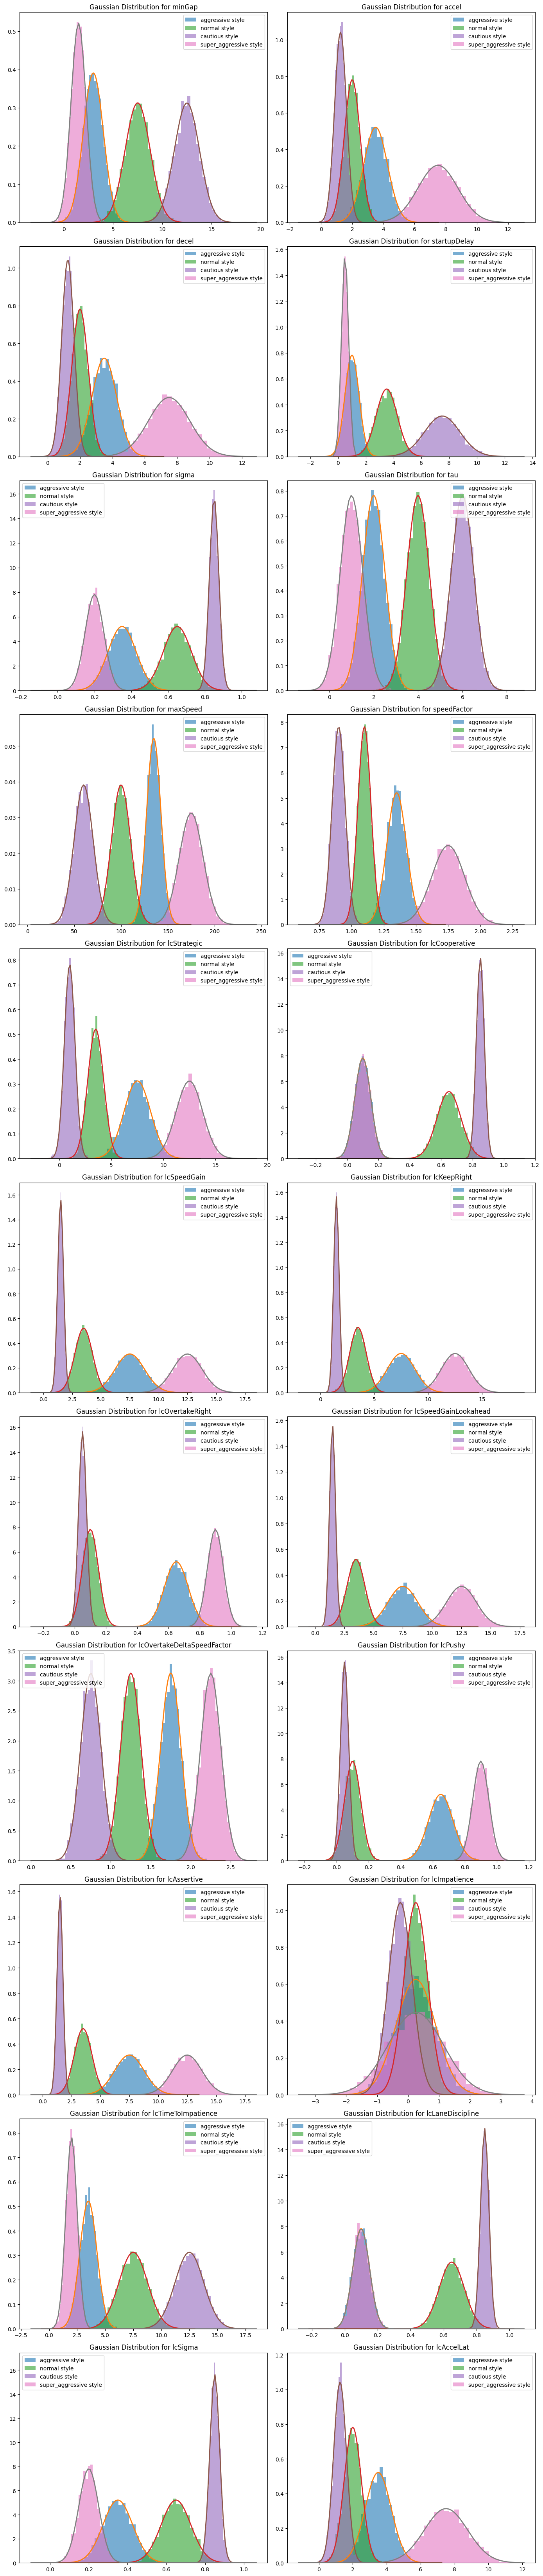

In [32]:
# Plot the distribution of the parameters for verification
vehParameters.showGaussianLLM(param_dict, [data['Parameter'][i] for i in range(len(data['Parameter']))], styles) 

In [59]:
# Setting the vehicle types for each student
n_vtypes = 5
veh_style_per_student = []
for i in range(len(location_time_list)):
    veh_style_per_student.append(styles[i % len(styles)]) # Balacing the styles for the vehicles

vehdists = vehParameters.generateVehicleTypesLLM(param_dict, styles, n_vtypes) # Generates the vehicle types for the vehicles
vehParameters.parseVehiclesXML(vehdists, styles, FOLDER_NAME) # Parses the vehicles to the XML format and writes it to vTypesDistribution.xml

'<vTypeDistribution id="aggressive">\n\t<vType id="v_aggressive0" minGap="0.73" accel="2.65" decel="3.33" startupDelay="0.57" sigma="0.51" tau="1.5" maxSpeed="150.37" speedFactor="1.41" lcStrategic="2.7" lcCooperative="0.37" lcSpeedGain="3.86" lcKeepRight="1.87" lcOvertakeRight="0.54" lcSpeedGainLookahead="2.82" lcOvertakeDeltaSpeedFactor="1.0" lcPushy="0.64" lcAssertive="4.1" lcImpatience="0.0" lcTimeToImpatience="1.32" lcLaneDiscipline="0.36" lcSigma="0.43" lcAccelLat="3.28" probability="0.2955337081639112">\n\t\t<param key="device.rerouting.probability" value="1.0"/>\n\t\t<param key="device.rerouting.adaptation-steps" value="18"/>\n\t\t<param key="device.rerouting.adaptation-interval" value="10"/>\n\t</vType>\n\t<vType id="v_aggressive1" minGap="1.0" accel="3.2" decel="3.27" startupDelay="0.96" sigma="0.44" tau="1.61" maxSpeed="139.22" speedFactor="1.36" lcStrategic="4.98" lcCooperative="0.35" lcSpeedGain="3.3" lcKeepRight="2.52" lcOvertakeRight="0.49" lcSpeedGainLookahead="2.64" lc

### Creating Random Trips to fill the simulation

Extracting the possible ids from the distribution to generate random trips

In [61]:
vtype_data = extract_vTypeDistribution(f"{FOLDER_NAME}/vTypesDistribution.xml")
vtype_data

{'aggressive': ['v_aggressive0',
  'v_aggressive1',
  'v_aggressive2',
  'v_aggressive3',
  'v_aggressive4'],
 'normal': ['v_normal0', 'v_normal1', 'v_normal2', 'v_normal3', 'v_normal4']}

In [62]:
rand_trips = None
final_trips_file_name = "finaltrips.rou.xml"

end_time = 1800
type_ids_random = getRandomTrips(NET_PATH, ADDITONALS_PATH, end_time, vtype_data, departure_step=2) # Generates equally distributed random trips for each vehicle class
print(type_ids_random)

Success.
Success.
Generated 864 vehicles.
{'aggressive': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153'

In [69]:
# Merging the trips generated by the LLM with the random trips
parseTripXML(param_dict, location_time_list, parkingAreas, departure_times, styles, veh_style_per_student, n_vtypes, steps_per_stop=10, rand_trips=rand_trips, out_file_name=final_trips_file_name) 

### Getting Alternative Routes for each trip

In [70]:
## Arguments to get alternative routes
duaiterate_path = "/usr/share/sumo/tools/assign/duaIterate.py"
def duaiterate_getArgs(net_path, trips_path, additional_path, iterations):
    args = [
        "-n", net_path,
        "-t", trips_path,
        "--additional", additional_path,
        "duarouter--additional-files", additional_path,
        "-l", str(iterations),
    ]
    return args

In [71]:
def getAltRoutes(net_path, trips_path, additional_path, iterations):
    # Run the duarouter to find alternative routes
    # Currently this only works for less than 10 iterations because of file naming
    try:
        subprocess.run(['python3', duaiterate_path] + duaiterate_getArgs(net_path, f'{FOLDER_NAME}/{trips_path}', additional_path, iterations), check=True)
        file_name = trips_path.split('.')[0]

        shutil.move(f'00{iterations-1}/{file_name}_00{iterations-1}.rou.alt.xml', f'{FOLDER_NAME}/{file_name}.rou.alt.xml')
        
        for i in range(iterations):
            if os.path.exists(f'00{i}'):
                shutil.rmtree(f'00{i}')

        shutil.move('dua.log', f'{FOLDER_NAME}/dua.log')
        shutil.move('stdout.log', f'{FOLDER_NAME}/stdout.log')
        os.remove('edgedata.add.xml')

        trips_id = {}
        tree = ET.parse(f"{FOLDER_NAME}/{file_name}.rou.alt.xml")
        root = tree.getroot()
        vehicles = root.findall('vehicle')
        for i in range(len(vehicles)):
            cls = re.sub(r'\d+', '', vehicles[i].get('type').split('_', 1)[1]) # Extracts the class of the vehicle by removing numbers and the first part of the type

            if cls not in trips_id.keys():
                trips_id[cls] = []

            trips_id[cls].append(vehicles[i].get('id'))
                
    except subprocess.CalledProcessError as e:
        print(f"{e}")

    return trips_id

In [72]:
# This creates the {final_trips_file_name}.rou.alt.xml file
type_ids_routines = getAltRoutes(NET_PATH, final_trips_file_name, ADDITONALS_PATH, 1)
print(type_ids_routines)

> Executing step 0
>> Running router on unicamp/finaltrips.rou.xml
>>> Begin time: 2025-02-06 17:00:38.660533
>>> End time: 2025-02-06 17:00:39.020766
>>> Duration: 0:00:00.360233
<<
>> Running simulation
>>> Begin time: 2025-02-06 17:00:39.020814
>>> End time: 2025-02-06 17:00:39.777421
>>> Duration: 0:00:00.756607
<<
< Step 0 ended (duration: 0:00:01.116959)
------------------

dua-iterate ended (duration: 0:00:01.121156)
{'aggressive': ['veh1', 'veh3'], 'normal': ['veh2', 'veh4']}


### Merging the trips and updating route files

If there is no need to generate alternative router for the random trips, the following XML parser must be used to add them:

In [73]:
def add_missing_vtypes(routes_file, types_file, output_file):
    # Parse the XML files
    routes_tree = ET.parse(routes_file)
    routes_root = routes_tree.getroot()
    types_tree = ET.parse(types_file)
    types_root = types_tree.getroot()
    
    # Extract existing vType IDs in routes_file
    existing_vtypes = {vtype.get('id') for vtype in routes_root.findall('vType')}
    
    # Find vTypes in types_file that are not in routes_file
    for vtype in types_root.findall(".//vType"):
        if vtype.get('id') not in existing_vtypes:
            routes_root.append(vtype)
    
    # Write the updated routes file
    routes_tree.write(output_file, encoding='utf-8', xml_declaration=True)
    print(f"Updated ROUTES_FILE saved as {output_file}")

In [74]:
def merge_routes(alternative_routes, random_routes, output_file_name = 'merged.rou.alt.xml'):
    # Merges two route files into one
    
    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'

    # Add missing vTypes to the alternative routes file
    add_missing_vtypes(alternative_routes, f'{FOLDER_NAME}/fixed_vTypeDistribution.xml', alternative_routes)

    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'
    
    with open(alternative_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if test.startswith('<vType'):
                start_read = True
            if start_read:
                if line.startswith('</routes>'):
                    break
                xml += line

    xml += '\n\n <!-- END - LLM Generated trips -->\n\n'
    xml += '<!-- BEGIN - Random Trips -->\n\n'

    with open(random_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if not start_read and (test.startswith('<vType') or test.startswith('<vehicle')):
                start_read = True
            if start_read:
                xml += line

    xml += '<!-- END - Random Trips -->\n\n'

    with open(f'{FOLDER_NAME}/{output_file_name}', 'w') as f:
        f.write(xml)

    
    return xml    

In [75]:
# If alternative routes for random trips were ignored, the 'merged.rou.alt.xml' file will be created and should be used in osm.sumocfg
output_file_name = 'merged.rou.alt.xml'
if rand_trips == None:
    if os.path.exists(f'{FOLDER_NAME}/{output_file_name}'):
        os.remove(f'{FOLDER_NAME}/{output_file_name}')
    
    # If there are alternative routes, merge them
    if os.path.exists(f'{FOLDER_NAME}/finaltrips.rou.alt.xml'):
        merge_routes(f'{FOLDER_NAME}/finaltrips.rou.alt.xml', f'{FOLDER_NAME}/randtrips.rou.xml', output_file_name)

    # If alternative routes were found not generated, we are going to use the original ones
    else:
        merge_routes(f'{FOLDER_NAME}/finaltrips.rou.xml', f'{FOLDER_NAME}/randtrips.rou.xml', output_file_name)

Updated ROUTES_FILE saved as unicamp/finaltrips.rou.alt.xml


In [76]:
# Changing sumocfg to use the new route file
add_xml_child(SUMOCFG_PATH, 'input', 'route-files', output_file_name)
print("All done! The SUMO configuration file has been updated to use the new route file.")
print(f"You can now run the simulation inside the {FOLDER_NAME} folder using `sumo-gui osm.sumocfg` or generate the data using the `simulationData.ipynb` notebook.")

Child <route-files> with value 'merged.rou.alt.xml' already exists. Skipping addition.
All done! The SUMO configuration file has been updated to use the new route file.
You can now run the simulation inside the unicamp folder using `sumo-gui osm.sumocfg` or generate the data using the `simulationData.ipynb` notebook.


In [77]:
print("IDs for the vehicles that were generated with routines:")
print(type_ids_routines)
print("IDs for the vehicles that were generated with random trips:")
print(type_ids_random)

IDs for the vehicles that were generated with routines:
{'aggressive': ['veh1', 'veh3'], 'normal': ['veh2', 'veh4']}
IDs for the vehicles that were generated with random trips:
{'aggressive': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '13